In [418]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [419]:
data = pd.read_csv('https://query.data.world/s/tu7xkafdc4jbuzmuh5zxqaeshwj7sv', encoding= 'unicode_escape')
data.tail()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E
239176,2013-09-01,NaN,NaN,Xian,China,34.56N,108.97E


In [420]:
data.drop(['City','Latitude','Longitude'], axis=1, inplace=True)

In [421]:
data['dt'] = pd.to_datetime(data['dt'])  
get_data = (data['dt'] > '2000-01-01') & (data['dt'] <= '2013-09-01')
df = data.loc[get_data]

In [422]:
df = df.loc[df['Country'].isin(['China'])]
display(df)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
49192,2000-02-01,-13.105,0.546,China
49193,2000-03-01,-1.089,0.284,China
49194,2000-04-01,7.297,0.216,China
49195,2000-05-01,16.970,0.272,China
49196,2000-06-01,23.371,0.253,China
...,...,...,...,...
239172,2013-05-01,18.979,0.807,China
239173,2013-06-01,23.522,0.647,China
239174,2013-07-01,25.251,1.042,China
239175,2013-08-01,24.528,0.840,China


In [423]:
df.drop(['Country'], axis=1, inplace=True)
df.reset_index(drop=True)

,dt,AverageTemperature,AverageTemperatureUncertainty
0,2000-02-01,-13.105,0.546
1,2000-03-01,-1.089,0.284
2,2000-04-01,7.297,0.216
3,2000-05-01,16.970,0.272
4,2000-06-01,23.371,0.253
...,...,...,...
2619,2013-05-01,18.979,0.807
2620,2013-06-01,23.522,0.647
2621,2013-07-01,25.251,1.042
2622,2013-08-01,24.528,0.840


In [424]:
df.dropna(subset=['AverageTemperature'],inplace=True)
df.dropna(subset=['AverageTemperatureUncertainty'],inplace=True)

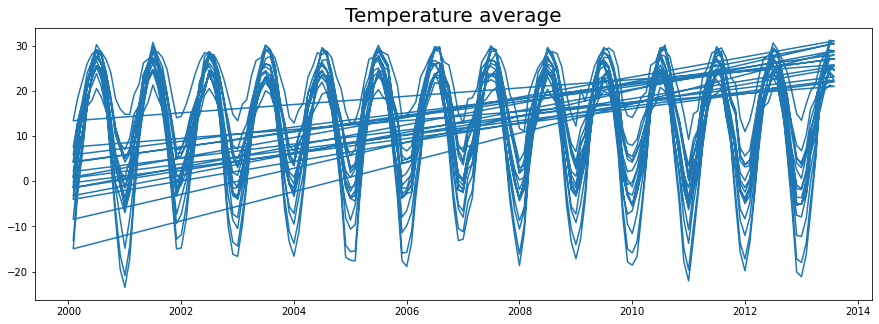

In [432]:
dates = df['dt'].values
temp  = df['AverageTemperature'].values

# dates = np.array(dates)
# temp = np.array(temp)

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [426]:
x_train, x_valid, y_train, y_valid = train_test_split(temp, dates, test_size = 0.2, shuffle = False )

In [427]:
Mae = (df['AverageTemperature'].max() - df['AverageTemperature'].min()) * 10/100
print(Mae)

5.4666


In [433]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [434]:
tf.keras.backend.set_floatx('float64')
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(LSTM(60)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [435]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<5.4 and logs.get('val_mae')<5.4):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [436]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data = val_set, callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


      6/Unknown - 7s 115ms/step - loss: 14.6794 - mae: 15.1743

21/21 [==============================] - 12s 242ms/step - loss: 14.2040 - mae: 14.6983 - val_loss: 14.2041 - val_mae: 14.6991
Epoch 2/100
21/21 [==============================] - 3s 122ms/step - loss: 13.9111 - mae: 14.4049 - val_loss: 13.8763 - val_mae: 14.3713
Epoch 3/100
21/21 [==============================] - 3s 119ms/step - loss: 13.6293 - mae: 14.1230 - val_loss: 13.5361 - val_mae: 14.0298
Epoch 4/100
21/21 [==============================] - 3s 123ms/step - loss: 13.3352 - mae: 13.8285 - val_loss: 13.1809 - val_mae: 13.6779
Epoch 5/100
21/21 [==============================] - 3s 129ms/step - loss: 13.0203 - mae: 13.5141 - val_loss: 12.8009 - val_mae: 13.2971
Epoch 6/100
21/21 [==============================] - 3s 142ms/step - loss: 12.6825 - mae: 13.1756 - val_loss: 12.3655 - val_mae: 12.8582
Epoch 7/100
21/21 [==============================] - 3s 121ms/step - loss: 12.3031 - mae: 12.7959 - val_loss: 11.8883 - val_mae: 12.3805
Epoch 8/100
21/21 [==============================] -